In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# The dataset shareable link

#new stylo data
#link = 'https://drive.google.com/open?id=1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N'
link = 'https://drive.google.com/open?id=15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l'

fluff, id = link.split('=')
print(id)
filename = 'stylo-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

#news stylo dataset
news_link = 'https://drive.google.com/open?id=1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c'
fluff, id = news_link.split('=')
print(id)
news_filename = 'news-data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(news_filename)

15e0XWZR1CYx0nyBOLasWJuwMyFgF-U5l
1C5MS8fWH2yS5GKS_TVddhuXPgR63JC-c


In [44]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold, SelectPercentile, SelectFwe, RFECV,  chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer

!pip install -U keras
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import InputLayer, Embedding, Conv1D, MaxPool1D, Dense, Flatten, Dropout, GRU, LSTM, Input
from tensorflow.python.keras import Sequential, Model
from keras.initializers import Constant

from pprint import pprint

from imblearn.over_sampling import SMOTE

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
# read dataset
df = pd.read_csv(filename)
df_news = pd.read_csv(news_filename)

# Remove single class entries (We need at least 3 samples of an author)#
df = df.groupby('Author').filter(lambda x: len(x) > 3)

In [0]:
#Separate data from labels

y = df.pop('Author')
y_news = df_news.pop('Author')

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

le.fit(y_news)
encoded_y_news = le.transform(y_news)

In [181]:
# Feature selection

# Baseline (Variance threshold):
threshold=(.01)
selector = VarianceThreshold(threshold)
selector.fit(df)

df.columns[selector.get_support(indices=True)] # 20 features, data has very low variance (features are mostly very close)

selector.fit(df_news)

df_news.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'MediaSilabasPorPalavra', 'Ponto', 'Virgulas', 'Exclamacoes',
       'DoisPontos', 'PronomesPorPreposicao', 'GuiraudR', 'HerdanV', 'MedidaK',
       'DugastU', 'BRFleshIndex'],
      dtype='object')

In [182]:
# 50% better based on percentile using chi2
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df, y)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'FrequenciaDeParagrafos', 'Ponto', 'Virgulas', 'Exclamacoes',
       'DoisPontos', 'PronomesPorPreposicao', 'FreqEAbstracao',
       'FreqEAcontecimento', 'FreqECoisa', 'FreqEOrganizacao', 'FreqEObra',
       'FreqEOutro', 'FreqEPessoa', 'FreqETempo', 'FreqEValor', 'GuiraudR',
       'HerdanV', 'DugastU', 'HonoresH', 'FrequenciaDeHapaxLegomenaLocal',
       'BRFleshIndex'],
      dtype='object')

In [183]:
selector = SelectPercentile(chi2, percentile=50)
selector.fit(df_news, y_news)
df.columns[selector.get_support(indices=True)]

Index(['DiversidadeLexica', 'TamanhoMedioDasPalavras', 'TamanhoMedioSentencas',
       'StdevSentencas', 'TamanhoMedioParagrafos', 'StdevTamParagrafos',
       'Ponto', 'Virgulas', 'Exclamacoes', 'DoisPontos', 'FreqCitacoes',
       'FreqAdv', 'FreqVerbosPtcp', 'FreqPronomes', 'PronomesPorPreposicao',
       'FreqTermosNaoTageados', 'FreqECoisa', 'FreqEObra', 'FreqEOutro',
       'FreqEPessoa', 'FreqETempo', 'GuiraudR', 'HerdanV', 'DugastU',
       'FreqPalavrasErradas', 'FrequenciaDeHapaxLegomenaLocal',
       'BRFleshIndex'],
      dtype='object')

In [184]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=54).fit(df, y)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature        Score
41                         HerdanV  1640.030726
5               StdevTamParagrafos  1190.145679
4           TamanhoMedioParagrafos  1083.505879
3                   StdevSentencas    83.212074
0                DiversidadeLexica    68.963605
2            TamanhoMedioSentencas    42.317390
43                         DugastU    40.001632
10                        Virgulas    12.506046
9                            Ponto     8.796392
12                      DoisPontos     8.654201
39                        GuiraudR     7.570860
11                     Exclamacoes     5.398750
52                    BRFleshIndex     2.558055
23           PronomesPorPreposicao     2.380678
47  FrequenciaDeHapaxLegomenaLocal     1.056917
1          TamanhoMedioDasPalavras     1.034314
45                        HonoresH     0.898729
30              FreqEAcontecimento     0.542428
37                      FreqETempo     0.538987
35                      FreqEOutro     0

In [185]:
# K-Best (chi2)
best_k_features = SelectKBest(chi2, k=54).fit(df_news, y_news)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature        Score
41                         HerdanV  2688.503948
5               StdevTamParagrafos  1707.831428
4           TamanhoMedioParagrafos  1103.327501
2            TamanhoMedioSentencas   862.748654
11                     Exclamacoes    59.697231
3                   StdevSentencas    59.007145
0                DiversidadeLexica    37.698913
43                         DugastU    33.392413
39                        GuiraudR    22.573796
10                        Virgulas    21.582665
9                            Ponto    16.308883
12                      DoisPontos    12.164414
23           PronomesPorPreposicao     6.568906
52                    BRFleshIndex     4.978543
1          TamanhoMedioDasPalavras     1.791226
24           FreqTermosNaoTageados     0.810441
35                      FreqEOutro     0.551372
34                       FreqEObra     0.526174
22                    FreqPronomes     0.487441
47  FrequenciaDeHapaxLegomenaLocal     0

In [186]:
# K-Best (f_classif)
best_k_features = SelectKBest(f_classif, k=54).fit(df, y)
dfscores = pd.DataFrame(best_k_features.scores_)
dfcolumns = pd.DataFrame(df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(54,'Score'))

                           Feature     Score
40                         HerdanC  3.929198
47  FrequenciaDeHapaxLegomenaLocal  3.897632
0                DiversidadeLexica  3.704376
45                        HonoresH  3.677677
3                   StdevSentencas  2.980987
10                        Virgulas  2.902532
7     FrequenciaPalavrasDuplicadas  2.701226
43                         DugastU  2.634572
9                            Ponto  2.433186
44                           MaasA  2.357812
28      FreqTotalEntidadesNomeadas  1.975839
1          TamanhoMedioDasPalavras  1.816000
51             FrequenciaStopWords  1.799109
2            TamanhoMedioSentencas  1.750471
4           TamanhoMedioParagrafos  1.721667
6           FrequenciaDeParagrafos  1.646904
50          FreqPalavrasComunsTam4  1.563717
41                         HerdanV  1.523790
14                   FreqAdjetivos  1.523693
42                         MedidaK  1.509841
37                      FreqETempo  1.461829
5         

In [187]:
estimator = RandomForestClassifier()
selector = RFECV(estimator, step=5, cv=3)
selector = selector.fit(df, y)
selector.support_
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 3])

Optimal number of features news-dataset: 38


<Figure size 432x288 with 0 Axes>

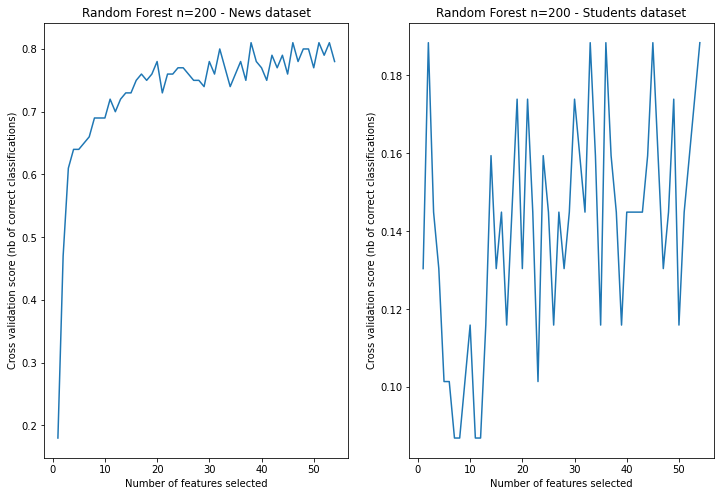

<Figure size 432x288 with 0 Axes>

In [188]:
# Create the RFE object and compute a cross-validated score.
rfc = RandomForestClassifier(n_estimators=200)
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features news-dataset: %d" % rfecv.n_features_)

rfecv2 = RFECV(estimator=rfc, step=1, cv=3,
              scoring='accuracy')
rfecv2.fit(df, y)

print("Optimal number of features students-dataset: %d" % rfecv2.n_features_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

ax1.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
ax1.set_xlabel("Number of features selected")
ax1.set_ylabel("Cross validation score (nb of correct classifications)")
ax1.set_title('Random Forest n=200 - News dataset')

ax2.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
ax2.set_xlabel("Number of features selected")
ax2.set_ylabel("Cross validation score (nb of correct classifications)")
ax2.set_title('Random Forest n=200 - Students dataset')

plt.figure()

Optimal number of features : 51


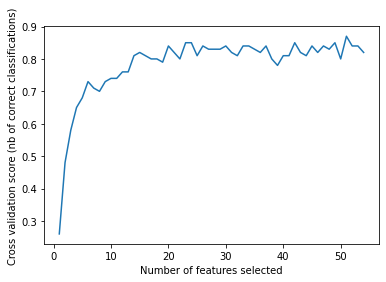

In [189]:
treeclf = ExtraTreesClassifier(n_estimators=400, random_state=11)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=treeclf, step=1, cv=5,
              scoring='accuracy')
rfecv.fit(df_news, y_news)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [0]:
X, X_test, Y, y_test = train_test_split(df_news.values, encoded_y_news, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

In [0]:
model = ExtraTreesClassifier(n_estimators=350, random_state=11)
model.fit(X, Y)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("Test score: %.2f%%" % (score * 100))

In [8]:
# Hyper-tuning our classifier

n_estimators = [int(x) for x in np.linspace(start = 150, stop = 1500, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                
etc = ExtraTreesClassifier(random_state=11)

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = etc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X, Y)

pprint(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                        

In [101]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

# Let's now check the accuracy with validation dataset (not seen by the classifier yet)
new_X = np.concatenate((X, X_test))
new_Y = np.concatenate((Y, y_test))

best_model.fit(new_X, new_Y)
predictions = best_model.predict(X_val)
base_score = accuracy_score(predictions, y_val)
print('Average accuracy:' + str(base_score))


#precision_recall_fscore_support(y_test, predictions, average='macro')

pprint(classification_report(y_val, predictions))

#print ("AUC&ROC",roc_auc_score(y_test, predictions, multi_class='ovr'))

Average accuracy:0.8
('              precision    recall  f1-score   support\n'
 '\n'
 '           1       1.00      0.67      0.80         3\n'
 '           2       1.00      1.00      1.00         1\n'
 '           3       0.00      0.00      0.00         2\n'
 '           4       0.67      1.00      0.80         2\n'
 '           5       1.00      1.00      1.00         1\n'
 '           6       1.00      1.00      1.00         1\n'
 '           7       0.50      1.00      0.67         1\n'
 '           8       0.50      1.00      0.67         1\n'
 '           9       1.00      1.00      1.00         3\n'
 '\n'
 '    accuracy                           0.80        15\n'
 '   macro avg       0.74      0.85      0.77        15\n'
 'weighted avg       0.76      0.80      0.76        15\n')


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TamanhoMedioParagrafos            0.041366
FrequenciaDeParagrafos            0.039795
FreqPalavrasDeConteudo            0.032172
MedidaK                           0.030311
Virgulas                          0.028687
HerdanV                           0.028467
GuiraudR                          0.028174
FreqTermosNaoTageados             0.026088
FreqPronomes                      0.025713
Ponto                             0.025130
TamanhoMedioDasPalavras           0.024142
FreqPalavrasErradas               0.024094
StdevTamParagrafos                0.024075
PronomesPorPreposicao             0.023781
Exclamacoes                       0.023748
FrequenciaStopWords               0.023270
StdevSentencas                    0.021758
FreqSubs                          0.021724
FreqVerbosPtcp                    0.020394
FreqAdv                           0.019843
FreqPrep                          0.019575
DugastU                           0.019374
MaasA                             0.017915
FreqArt    

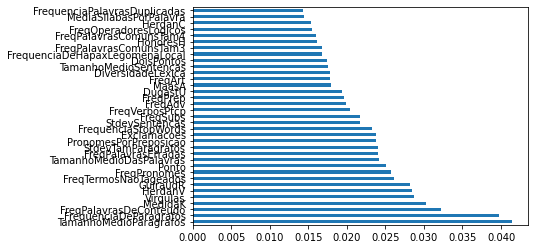

In [103]:
feat_importances = pd.Series(best_model.feature_importances_, index=df_news.columns)
feat_importances.nlargest(35).plot(kind='barh')
print(feat_importances.nlargest(35))
plt.show()

In [193]:
X, X_test, Y, y_test = train_test_split(df_news.values, encoded_y_news, random_state=7, test_size=0.3)

treeclf = ExtraTreesClassifier(n_estimators=400, random_state=11)

clf = Pipeline([
  ('feature_selection', RFECV(estimator=treeclf, step=1, cv=5, scoring='accuracy')),
  ('classification', ExtraTreesClassifier(random_state=11))
])
clf.fit(X, Y)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("Test score: %.2f%%" % (score * 100))

Test score: 76.67%


In [196]:
X, X_test, Y, y_test = train_test_split(df_news, encoded_y_news, random_state=7, test_size=0.3)
#X, X_test, Y, y_test = train_test_split(df.values, encoded_Y, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

test_scores = []
val_scores = []
for i in range(0,10):

  model = ExtraTreesClassifier(n_estimators=400, random_state=11)
  model.fit(X, Y)

  y_pred = model.predict(X_test)

  score = accuracy_score(y_test, y_pred)
  #print("Test score: %.2f%%" % (score * 100))
  test_scores.append(score * 100)

  y_pred = model.predict(X_val)
  score = accuracy_score(y_val, y_pred)
  #print("Validation score: %.2f%%" % (score * 100))
  val_scores.append(score * 100)


print("Test score: %.2f%%" % (np.mean(test_scores)))
print("Validation score: %.2f%%" % (np.mean(val_scores)))


Test score: 67.33%
Validation score: 74.00%


In [0]:
# Let's manually imballance the dataset to make it look more like students dataset
from random import randrange

df_test = pd.read_csv(news_filename)

safe_ids = [i for i in set([randrange(5) * i for i in range(1,40)]) if i < 100]
df_test = df_test.drop(safe_ids)
df_test.shape

# Let's remove more samples for the first 3 classes
def remove_by_author(author, df):
  for idx in df.loc[df['Author'] == author].index:
    #lets give 0.5 chance to drop each feature
    chance = randrange(2)
    if chance == 1:
      df = df.drop(idx)
  return df

df_test = remove_by_author("'SP'", df_test)
df_test = remove_by_author("'VSAL'", df_test)
df_test = remove_by_author("'MC'", df_test)
df_test = remove_by_author("'KM'", df_test)

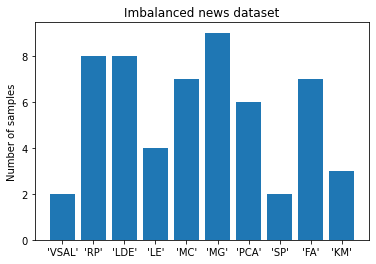

In [73]:
authors = {}
for author in set(df_test['Author']):
  authors[author] = len(df_test.loc[df_test['Author'] == author])

height = authors.values()
bars = authors.keys()
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
 
plt.title('Imbalanced news dataset')
plt.ylabel('Number of samples')
plt.show()

In [0]:
#Separate data from labels
y_news_imbalanced = df_test.pop('Author')

le = LabelEncoder()
le.fit(y_news_imbalanced)
encoded_Y_news_imbalanced = le.transform(y_news_imbalanced)

In [0]:
# Now let's use our best classifier from balanced dataset do see accuracy after imbalance

X, X_test, Y, y_test = train_test_split(df_test.values, encoded_Y_news_imbalanced, random_state=7, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=7, test_size=0.5)

# Hyper-tuning our classifier
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 1500, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                

rf_random_imbalanced = RandomizedSearchCV(estimator = ExtraTreesClassifier(random_state=11), 
                                          param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random_imbalanced.fit(X, Y)

pprint(rf_random_imbalanced.best_params_)

best_imbl_model = rf_random_imbalanced.best_estimator_
imbl_predictions = best_imbl_model.predict(X_test)
best_score = accuracy_score(imbl_predictions, y_test)
print(best_score)

In [94]:
# Let's now check the accuracy of our new imbalanced model
new_X = np.concatenate((X, X_test))
new_Y = np.concatenate((Y, y_test))

best_imbl_model.fit(new_X, new_Y)
imbl_predictions = best_imbl_model.predict(X_val)
best_score = accuracy_score(imbl_predictions, y_val)

# It looks like class imbalance was not a problem after all
print(best_score)

0.7777777777777778


In [0]:
# TensorFlow 2.x is causing neural networks not to work correctly - please run this locally 
X, X_test, Y, y_test = train_test_split(df_news, encoded_y_news, random_state=11, test_size=0.3)
model = Sequential()
model.add(Dense(12, input_dim=54, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, Y, epochs=250, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))